In [1]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from datetime import datetime
import sqlite3
from random import randint
import pandas as pd
import plotly.graph_objs as go


from core import (create_stat_table,
                  make_full_analyses_anomalies,
                  make_pieplot_plotly,
                  process_data)


### Test 1

#### Исходные данные

##### Таблица 1. Статистика показов рекламы в рекламных блоках

`stat_collector`:

- `block_id`: id рекламного блока (INT)
- `shows`: показы (INT)
- `good_clicks`: "хорошие" клики (INT)
- `fraud_clicks`: фродовые клики (INT)
- `revenue`: доход сайта (FLOAT)

##### Таблица 2. Словарь соответствия рекламных блоков доменам, на которых те установлены

`block_domains`:

- `block_id`: id рекламного блока (INT)
- `block_description`: описание рекламного блока (VARCHAR)
- `domain_id`: id сайта (INT)
- `domain_name`: название сайта (VARCHAR)


In [2]:
conn = sqlite3.connect('advertising.db')
c = conn.cursor()
c.execute('''DROP TABLE IF EXISTS stat_collector;''')
c.execute('''
    CREATE TABLE IF NOT EXISTS stat_collector
    (block_id INT PRIMARY KEY,
    shows INT,
    good_clicks INT,
    fraud_clicks INT,
    revenue FLOAT)
''')
c.execute('''DROP TABLE IF EXISTS block_domains;''')
c.execute('''
    CREATE TABLE IF NOT EXISTS block_domains
    (block_id INT PRIMARY KEY,
    block_description TEXT,
    domain_id INT,
    domain_name TEXT)
''')
for i in range(1, 101):
    c.execute(f"INSERT INTO stat_collector VALUES ({i}, {i*1000}, {i*randint(0, 100)}, {i*randint(0, 100)}, {i*100.0})")
for i in range(1, 101):
    c.execute(f"INSERT INTO block_domains VALUES ({i}, 'Block {i}', {i}, 'Site {i}')")
conn.commit()
conn.close()


### 1.1
Необходимо вывести доход, который принесли только хорошие клики (good_clicks)?

Answer:

```sql
SELECT SUM((revenue / (good_clicks + fraud_clicks)) * good_clicks)  FROM stat_collector;`

In [3]:
import sqlite3
conn = sqlite3.connect('advertising.db')
c = conn.cursor()
c.execute('''
SELECT SUM((revenue / (good_clicks + fraud_clicks)) * good_clicks)  FROM stat_collector;
''')
results = c.fetchall()
for row in results:
    print(row)
conn.close()


(283405.62505415047,)


### 1.2

Необходимо вывести топ-10 сайтов по обороту среди тех, которые имеют более 25% плохих кликов.


Answer:

```sql
SELECT domain_name
FROM block_domains
WHERE block_id IN (
    SELECT block_id
    FROM stat_collector
    WHERE (fraud_clicks / (good_clicks + fraud_clicks)) >= 0.25
    ORDER BY revenue DESC
    LIMIT 10
);


In [4]:
import sqlite3
conn = sqlite3.connect('advertising.db')
c = conn.cursor()
c.execute( '''
SELECT domain_name
FROM block_domains
WHERE block_id IN (
SELECT block_id
FROM stat_collector
WHERE (fraud_clicks / (good_clicks + fraud_clicks)) >= 0.25
ORDER BY revenue DESC
LIMIT 10)''')
results = c.fetchall()
for row in results:
    print(row)
conn.close()


In [5]:
import sqlite3
conn = sqlite3.connect('advertising.db')
c = conn.cursor()
c.execute( '''
SELECT COUNT(block_id)
FROM stat_collector
WHERE (fraud_clicks / (good_clicks + fraud_clicks)) >= 0.25''')
results = c.fetchall()
for row in results:
    print(row)
conn.close()


(0,)


### Задание 2

Кейс
"Рекламодатель Сигма жалуется на постоянный рост CPA по своим рекламным кампаниям в последние 4 месяца (с июня по сент 2022). Ваша задача проанализировать его размещение с целью:
1) Выяснить причину растущего CPA
2) Дать рекомендации по снижению и стабилизации CPA до целевого значения (380 руб)"

Исходные данные
Лист data

Описание столбцов таблицы на Листе data
Описание столбцов:
- Client – название клиента
- Device – тип устройства
- Place – тип площадки
- BannerType – тип объявления
- QueryType – тип запроса
- TargetingType – тип таргетинга
- Cost - расходы рекламодателя
- Conversions – целевые визиты

Ожидаемый результат
- Презентация в ppt с выводами и графиками
- Исходники с расчетами в свободном, но структурированном и читаемом формате (на ваше усмотрение - ссылки на xlsx-файл, data studio, bi и тд)

Дополнительная информация
Для выполнения задания потребуются базовые знания по Яндекс.Директу.
Всю информацию можно найти в официальной справке: https://yandex.ru/support/direct/


2024-04-14 18:37:48,277 - INFO - первое представление о данных


,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions,cpa,cpc,cpa_2
0,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Phrase,0,0,0.000000,0,0.0,0.000000,0.0
1,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Retargeting,5949,41,1666.844364,0,0.0,40.654741,0.0
2,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,cpc_video,none,Retargeting,191,6,40.641915,0,0.0,6.773653,0.0
3,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,image_ad,none,Retargeting,227,1,45.747407,0,0.0,45.747407,0.0
4,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,18,0,0.000000,0,0.0,0.000000,0.0


****************************************************************************************************


,Month,Shows,Clicks,Cost,Conversions,cpa,cpc,cpa_2
count,10478,1.047800e+04,1.047800e+04,1.047800e+04,10478.000000,1.047800e+04,10478.000000,10478.000000
mean,2021-12-23 01:32:37.701851648,1.715049e+06,9.769437e+03,3.598293e+05,507.982344,5.256544e+03,61.426505,8.013075
min,2021-04-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,2021-08-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
50%,2022-01-01 00:00:00,1.181150e+04,2.805000e+02,1.304677e+04,2.000000,1.557916e+02,19.705705,0.006855
75%,2022-05-01 00:00:00,1.326425e+05,5.130250e+03,2.111534e+05,94.000000,1.317728e+03,62.716138,0.773969
max,2022-09-01 00:00:00,5.831506e+08,2.237376e+06,3.976618e+07,47259.000000,2.227386e+06,1981.225805,1193.905398
std,NaN,1.544924e+07,4.454819e+04,1.211802e+06,2086.404812,4.136944e+04,129.500891,50.661585


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10478 entries, 0 to 10477
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   10478 non-null  object        
 1   Month                    10478 non-null  datetime64[ns]
 2   Category                 10478 non-null  object        
 3   Device                   10478 non-null  object        
 4   Place                    10478 non-null  object        
 5   BannerType               10478 non-null  object        
 6   QueryType (search only)  10478 non-null  object        
 7   TargetingType            10478 non-null  object        
 8   Shows                    10478 non-null  int64         
 9   Clicks                   10478 non-null  int64         
 10  Cost                     10478 non-null  float64     

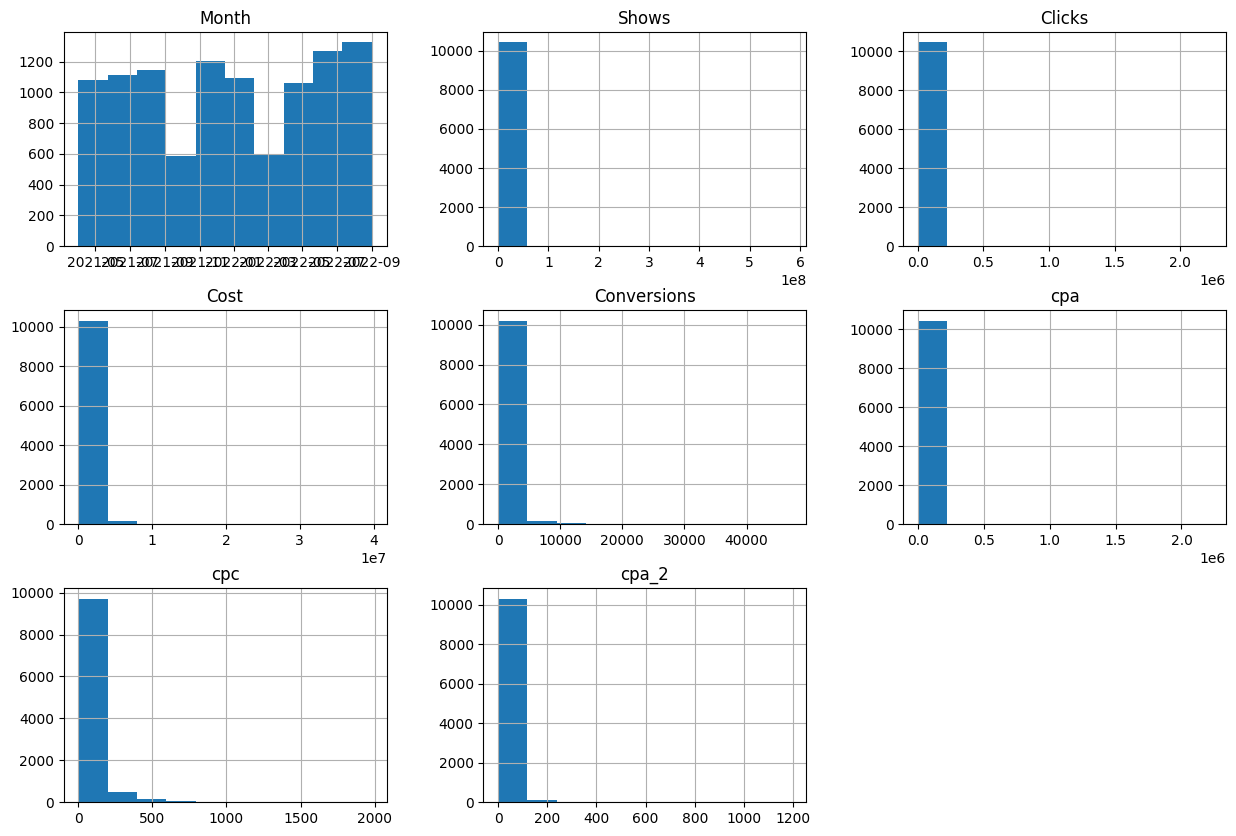

2024-04-14 18:37:49,563 - INFO - пропусков не нашел
2024-04-14 18:37:49,594 - INFO - поменяли на временной формат колоку
2024-04-14 18:37:49,594 - INFO - Month
2024-04-14 18:37:49,650 - INFO - дубликатов не найдено


In [6]:
data = pd.read_excel("C:/Dev/test_yd_2024/Задание_стажировка_рекламный аналитик_2024.xlsx", sheet_name='data')
data['cpa'] = data.apply(lambda row: 0 if row['Conversions'] == 0 else row['Cost'] / row['Conversions'], axis=1)
data['cpc'] = data.apply(lambda row: 0 if row['Clicks'] == 0 else row['Cost'] / row['Clicks'], axis=1)
data['cpa_2'] = data.apply(lambda row: 0 if row['Conversions'] == 0 else row['cpc'] / row['Conversions'], axis=1)

data = process_data(data)
data = data.rename(columns={'QueryType (search only)': 'QueryType'})


In [7]:
print('таргетинг: ', *data['TargetingType'].unique())
print('Клиенты: ', *data['Client'].unique())
print(f'Данные представлены с {data["Month"].min()} по {data["Month"].max()}')
for column, name in {'Category': 'категориям', 'Device': 'типу устройст',
                     'Place': 'типу площадки', 'BannerType': 'типу объявления',
                     'QueryType': 'типу запроса',
                     'TargetingType': 'типу таргетинга'}.items():
    make_pieplot_plotly(column, 'cpa', 'count', f'распределение по {name}', data)
for column in ['Shows', 'Clicks', 'Cost', 'Conversions', 'cpa']:
    print(column)
    make_full_analyses_anomalies(data, column)
    print("*"*100)


таргетинг:  phrase retargeting autotargeting
Клиенты:  псилон гамма дельта сигма омега зета бета альфа мета лямбда
Данные представлены с 2021-04-01 00:00:00 по 2022-09-01 00:00:00


Shows


interactive(children=(Dropdown(description='graphs', options=('boxplot', 'detail_box_plot', 'scatterplot', 'vi…

iqr - 132641.5
q75 - 132642.5
q25 - 1.0
минимальное неаномальное значение 0 
максимальное неаномальное значение 331604.75
выбросов % -  15.47


Button(button_style='info', description='Узнать больше!', style=ButtonStyle())

****************************************************************************************************
Clicks


interactive(children=(Dropdown(description='graphs', options=('boxplot', 'detail_box_plot', 'scatterplot', 'vi…

iqr - 5130.25
q75 - 5130.25
q25 - 0.0
минимальное неаномальное значение 0 
максимальное неаномальное значение 12825.625
выбросов % -  15.3


Button(button_style='info', description='Узнать больше!', style=ButtonStyle())

****************************************************************************************************
Cost


interactive(children=(Dropdown(description='graphs', options=('boxplot', 'detail_box_plot', 'scatterplot', 'vi…

iqr - 211153.426258474
q75 - 211153.426258474
q25 - 0.0
минимальное неаномальное значение 0.0 
максимальное неаномальное значение 527883.5656461851
выбросов % -  15.94


Button(button_style='info', description='Узнать больше!', style=ButtonStyle())

****************************************************************************************************
Conversions


interactive(children=(Dropdown(description='graphs', options=('boxplot', 'detail_box_plot', 'scatterplot', 'vi…

iqr - 94.0
q75 - 94.0
q25 - 0.0
минимальное неаномальное значение 0 
максимальное неаномальное значение 235.0
выбросов % -  19.14


Button(button_style='info', description='Узнать больше!', style=ButtonStyle())

****************************************************************************************************
cpa


interactive(children=(Dropdown(description='graphs', options=('boxplot', 'detail_box_plot', 'scatterplot', 'vi…

iqr - 1317.7283286795985
q75 - 1317.7283286795985
q25 - 0.0
минимальное неаномальное значение 0.0 
максимальное неаномальное значение 3294.320821698996
выбросов % -  14.47


Button(button_style='info', description='Узнать больше!', style=ButtonStyle())

****************************************************************************************************


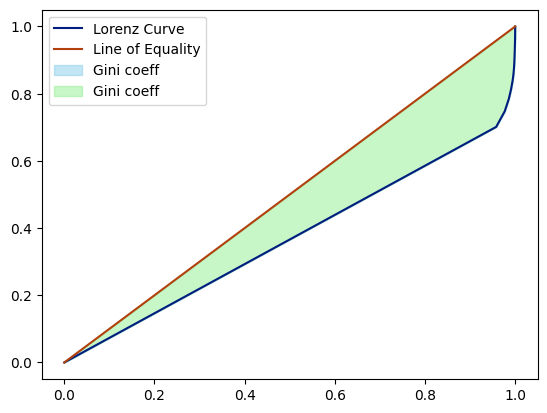

FloatText(value=13394.804968887192, description='Среднее:')

FloatText(value=1640445836.9914563, description='Дисперсия:')

FloatText(value=40502.417668473274, description='Среднеквадратическое отклонение:')

FloatText(value=3.0237407534152485, description='Коэффициент вариации:')

FloatSlider(value=0.5, description='Квартиль:', max=1.0, step=0.01)

FloatText(value=0.0, description='Значение квартиля:')

FloatText(value=11399.430266839378, description='Медиана:')

FloatText(value=0.26331794034948, description='Джини:')

IntText(value=1, description='Порядок:')

FloatText(value=0.0, description='Значение:')

Dropdown(description='Момент:', options=('Центральный момент', 'Центральный момент к значению a', 'Простой мом…

FloatText(value=0.0, description='Значение момента:')

Dropdown(description='Атрибут:', options=('Юль', 'Пирсон', 'Фишер', 'Аплатиссемент Пирсон', 'Аплатиссемент Фиш…

FloatText(value=0.0, description='Значение атрибута:')

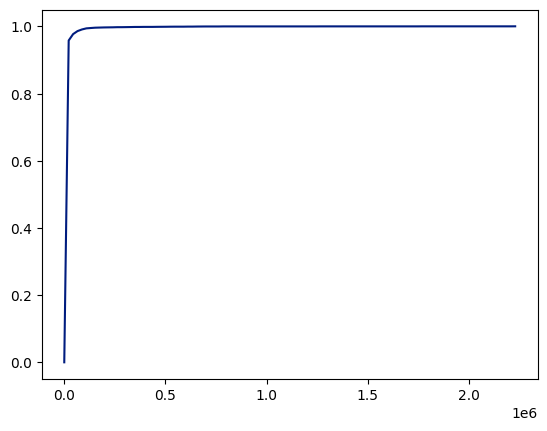

In [8]:
create_stat_table(data['cpa'])

In [9]:
external_stylesheets: list[str] = [
    'https://codepen.io/chriddyp/pen/bWLwgP.css'
    ]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets,
                compress=False)


colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

app.layout = html.Div(style={'backgroundColor': colors['background']},
                      children=[
    html.H1(children='CPA analyse',
            style={
             'textAlign': 'center',
             'color': colors['text']
            }),
    html.Br(),
# selectors first line
    html.Div([
        html.Div([
            html.Label('Временной период:',
             style={'textAlign': 'center', 'color': colors['text']}),
            dcc.DatePickerRange(start_date=data['Month'].dt.date.min(),
                                end_date=data['Month'].dt.date.max(),
                                display_format='YYYY-MM-DD',
                                id='dt_selector',
                                style={'textAlign': 'center', 'color': 'blue', 'backgroundColor': colors['background']}),
         ],
             className='two columns'),
        html.Div([
            html.Label('Компании:',
                 style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'Client'
                ].unique()],
                         value=data['Client'].unique().tolist(),
                         multi=True,
                         id='company_selector',
                         style={'backgroundColor': colors['background']}),
        ], className='four columns'),
        html.Div([
            html.Label('Device: ', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'Device'
                ].unique()],
                         value=data['Device'].unique().tolist(),
                         multi=True,
                         id='device_selector',
                         style={'backgroundColor': colors['background']}), 
        ], className='two columns'),
        html.Div([
            html.Label('Places: ', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'Place'
                ].unique()],
                         value=['search'],
                         multi=True,
                         id='place_selector',
                         style={'backgroundColor': colors['background']}),], className='two columns'),
        html.Div([
            html.Label('QueryType: ', style={'textAlign': 'center', 'color': colors['text']}, id='query_label'),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'QueryType'
                ].unique()],
                         value=data['QueryType'].unique().tolist(),
                         multi=True,
                         id='query_selector'), 
                         ], className='two columns'),
    ], className='row'),
    html.Br(),
# selectors second line
    html.Div([
        html.Div([
            html.Label('Режим отображения:',
                       style={'textAlign': 'center', 'color': colors['text']}),
            dcc.RadioItems(options=[
                {'label': html.Div(['абсолютные значения'],
                                   style={'color': 'Gold',
                                          'font-size': 12}),
                           'value': 'absolute_values'},
                {'label': html.Div(['прирост'],
                                   style={'color': 'Gold',
                                          'font-size': 12}),
                    'value': 'relative_values'},
            ],
             value='absolute_values',
             id='mode_selector',
             style={'backgroundColor': colors['background']}),
        ], className='two columns'),
        html.Div([
            html.Label('BannerType: ', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'BannerType'
                ].unique()],
                         value=data['BannerType'].unique().tolist(),
                         multi=True,
                         id='banner_selector',
                         style={'backgroundColor': colors['background']}),], className='four columns'),
        html.Div([
            html.Label('TargetingType: ', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'TargetingType'
                ].unique()],
                         value=data['TargetingType'].unique().tolist(),
                         multi=True,
                         id='target_selector',
                         style={'backgroundColor': colors['background']}),], className='two columns'),
        html.Div([
            html.Label('Category: ', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Dropdown(options=[{'label': x, 'value': x} for x in data[
                'Category'
                ].unique()],
                         value=data['Category'].unique().tolist(),
                         multi=True,
                         id='category_selector',
                         style={'backgroundColor': colors['background']}),], className='four columns'),
    ], className='row'),
    html.Br(),
# graphs (lines)
    html.Div([
    html.Div([
            html.Label('Метрика:',
                       style={'textAlign': 'center', 'color': colors['text']}),
            dcc.RadioItems(options=[
                {'label': html.Div(['cpa'],
                                   style={'color': 'Gold',
                                          'font-size': 12}),
                           'value': 'cpa'},
                {'label': html.Div(['cpc'],
                                   style={'color': 'Gold',
                                          'font-size': 12}),
                    'value': 'cpc'},
                {'label': html.Div(['cpa_2'],
                                   style={'color': 'Gold',
                                          'font-size': 12}),
                    'value': 'cpa_2'},
            ],
             value='cpa',
             id='metric_selector',
             style={'backgroundColor': colors['background']}),
        ], className='two columns'),
    html.Div([
        html.Label('CPA', style={'textAlign': 'center', 'color': colors['text']}),
        dcc.Graph(id='cpa_line'),
    ], className='ten columns'),
    html.Div([
        html.Label('Costs', style={'textAlign': 'center', 'color': colors['text']}),
        dcc.Graph(id='cost_line'),
    ], className='five columns'),
    html.Div([
        html.Label('Conversions', style={'textAlign': 'center', 'color': colors['text']}),
        dcc.Graph(id='conversions_line'),
    ], className='five columns'),
    html.Div([
        html.Label('Clicks', style={'textAlign': 'center', 'color': colors['text']}),
        dcc.Graph(id='clicks_line'),
    ], className='five columns'),
    html.Div([
        html.Label('Shows', style={'textAlign': 'center', 'color': colors['text']}),
        dcc.Graph(id='shows_line'),
    ], className='five columns'),], className='row'),
    html.Div([
        html.Div([
            html.Label('cpa/conversions/costs', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Graph(id='bar_plot')], className='twelve columns')
    ], className='row'),
    html.Div([
        html.Div([
            html.Label('3d cpa/conversions/costs', style={'textAlign': 'center', 'color': colors['text']}),
            dcc.Graph(
                figure = {
                    'data': [go.Scatter3d(
                            x=data['Cost'],
                            y=data['Conversions'],
                            z=data['cpa'],
                            mode='markers',
                            marker=dict(
                                size=12,
                                colorscale='Viridis',
                                opacity=0.8
                            )
                    )],
                    'layout': go.Layout(scene = dict(
                                        xaxis_title='Cost',
                                        yaxis_title='Conversions',
                                        zaxis_title='CPA'
                    ),
                    plot_bgcolor=colors['background'],
                    paper_bgcolor=colors['background'],
                    font={'color': colors['text']},
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
                )
                },
                id = 'cost_conv_cpa'
            )],className='twelve columns')
        ], className='row'),

    html.Div([
        html.Div(id='output-container-date-picker')
    ], className='row')
])


@app.callback(
    Output('query_selector', 'style'),
    Input('place_selector', 'value')
)
def show_hide_element(place):
    if len(place) == 1 and place[0] == 'search':
        return {'display': 'block', 'backgroundColor': colors['background']}
    else:
        return {'display': 'none'}


@app.callback(
    [Output('cpa_line', 'figure'),
     Output('conversions_line', 'figure'),
     Output('clicks_line', 'figure'),
     Output('shows_line', 'figure'),
     Output('cost_line', 'figure'),
     Output('bar_plot', 'figure'),],
    [Input('dt_selector', 'start_date'),
     Input('dt_selector', 'end_date'),
     Input('device_selector', 'value'),
     Input('company_selector', 'value'),
     Input('place_selector', 'value'),
     Input('query_selector', 'value'),
     Input('banner_selector', 'value'),
     Input('target_selector', 'value'),
     Input('category_selector', 'value'),
     Input('mode_selector', 'value'),
     Input('metric_selector', 'value'),])
def update_figures(start_date, end_date,
                  select_device, selected_companys,
                  select_place, select_query,
                  select_banner, select_target, select_category, mode, column, data=data):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    query = '''Month >= @start_date
                                   and Month <= @end_date
                                   and Client in @selected_companys
                                   and Category in @select_category
                                   and Device in @select_device
                                   and Place in @select_place
                                   and BannerType in @select_banner
                                   and TargetingType in @select_target'''
    filtered_data = data.query(query.replace('\n', ' '))
    if len(select_place) == 1 and select_place[0] == 'search':
         filtered_data = filtered_data.query('QueryType in @select_query')
    if mode == 'relative_values':
        filtered_data[['Shows', 'Clicks', 'Cost', 'Conversions', 'cpa']] = filtered_data[['Shows', 'Clicks', 'Cost', 'Conversions', 'cpa']].pct_change()
    data_company = []
    for company in filtered_data['Client'].unique():
        data_company += [go.Scatter(x=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({column: 'median'}).reset_index()['Month'],
                            y=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({column: 'median'})[column],
                            mode='lines',
                            name=company)]
    if mode != 'relative_values':
        data_company += [go.Scatter(x=filtered_data.query('Client == "сигма"')['Month'],
                            y=[380 for _ in range(len(filtered_data))],
                            mode='lines',
                            line=dict(dash='dot'),
                            marker_color='red',
                            name='целевое значение' 
                            )]
    conversions = []
    for company in filtered_data['Client'].unique():
        conversions += [go.Scatter(x=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Conversions': 'median'}).reset_index()['Month'],
                            y=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Conversions': 'median'})['Conversions'],
                            mode='lines',
                            name=company)]
    clicks = []
    for company in filtered_data['Client'].unique():
        clicks += [go.Scatter(x=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Clicks': 'median'}).reset_index()['Month'],
                            y=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Clicks': 'median'})['Clicks'],
                            mode='lines',
                            name=company)]
    shows = []
    for company in filtered_data['Client'].unique():
        shows += [go.Scatter(x=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Shows': 'median'}).reset_index()['Month'],
                            y=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Shows': 'median'})['Shows'],
                            mode='lines',
                            name=company)]
    cost = []
    for company in filtered_data['Client'].unique():
        cost += [go.Scatter(x=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Cost': 'median'}).reset_index()['Month'],
                            y=filtered_data.query('Client == @company').groupby(by=["Month"]).agg({'Cost': 'median'})['Cost'],
                            mode='lines',
                            name=company)]
    return (
                {
                    'data': data_company,
                    'layout': go.Layout(xaxis={'title': 'Month'},
                                        yaxis={'title': 'CPA'},
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                 },
                {
                    'data': conversions,
                    'layout': go.Layout(xaxis={'title': 'Month'},
                                        yaxis={'title': 'Conversions'},
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                 },
                {
                    'data': clicks,
                    'layout': go.Layout(xaxis={'title': 'Month'},
                                        yaxis={'title': 'Clicks'},
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                },
                 {
                    'data': shows,
                    'layout': go.Layout(xaxis={'title': 'Month'},
                                        yaxis={'title': 'Shows'},
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                },
                 {
                    'data': cost,
                    'layout': go.Layout(xaxis={'title': 'Month'},
                                        yaxis={'title': 'Cost'},
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                },
                {
                    'data': [
                        go.Bar(x=filtered_data['Month'], y=filtered_data['Cost'], name='Затраты'),
                        go.Bar(x=filtered_data['Month'], y=filtered_data['Conversions'], name='Конверсии'),
                        go.Bar(x=filtered_data['Month'], y=filtered_data[column], name=column),
                        ],
                    'layout': go.Layout(barmode='stack',
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                }
    )


@app.callback(
    Output('output-container-date-picker', 'children'),
    [Input('device_selector', 'value'),
     Input('company_selector', 'value'),
     Input('place_selector', 'value'),
     Input('query_selector', 'value'),
     Input('banner_selector', 'value'),
     Input('target_selector', 'value'),
     Input('category_selector', 'value'),]
)
def update_output(select_device, selected_companys,
                  select_place, select_query,
                  select_banner, select_target, select_category):
    query = '''Client in @selected_companys
                and Category in @select_category
                and Device in @select_device
                and Place in @select_place
                and BannerType in @select_banner
                and TargetingType in @select_target'''
    filtered_data = data.query(query.replace('\n', ' '))
    if len(select_place) == 1 and select_place[0] == 'search':
         filtered_data = filtered_data.query('QueryType in @select_query')
    figures = []
    for feature in ['Category', 'Device', 'Place', 'BannerType', 'QueryType', 'TargetingType']:
        filtered_df_before = filtered_data[filtered_data['Month'] < datetime(2022, 6, 1)]
        filtered_df_after = filtered_data[filtered_data['Month'] >= datetime(2022, 6, 1)]
        data_before = [
            go.Pie(labels=filtered_df_before[feature].unique(), values=filtered_df_before[feature].value_counts())
        ]
        data_after = [
            go.Pie(labels=filtered_df_after[feature].unique(), values=filtered_df_after[feature].value_counts())
        ]
        figures.append(html.Div([
            dcc.Graph(
                id=f'{feature}-pie-chart-before',
                figure={
                    'data': data_before,
                    'layout': go.Layout(title=f'Распределение {feature} до {datetime(2022, 6, 1)}',
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                }
            ),
            dcc.Graph(
                id=f'{feature}-pie-chart-after',
                figure={
                    'data': data_after,
                    'layout': go.Layout(title=f'Распределение {feature} после {datetime(2022, 6, 1)}',
                                        plot_bgcolor=colors['background'],
                                        paper_bgcolor=colors['background'],
                                        font={'color': colors['text']})
                }
            )
        ], style={'display': 'flex'}))
    return figures


if __name__ == '__main__':
    app.run_server(debug=False, mode='inline')

## Анализ CPA

### Анализ mobile - networks

1. **CPA (затраты/конверсия)**: Растет стабильно, максимальное значение - 250.
2. **CPC**: Около нуля.
3. **CPA (CPC/конверсии)**: Также растет около нуля.
4. **Издержки**: Являются возрастающей функцией.
5. **Конверсия, клики, показы**: Сначала растут до июня, а в августе сильно убывают.
6. **Темпы прироста CPA**: Отрицательные темпы прироста до июня.
7. **Темпы прироста CPC**: Увеличиваются.
8. **Темпы прироста CPA_2**: Такие же, как у CPC, но темпы прироста значительно ниже.
9. **Темпы прироста затрат**: Отрицательные в августе.
10. **Структура выбора баннеров**: Сильно изменилась (текст 60 -> 18%, изображение 32% -> 67%, CPM-баннер 6 -> 14%).

### Анализ modile - search

1. **CPA, CPC, (CPC/конверсии)**: CPA от 150-340, остальные менее ста.
2. **Темпы прироста CPA**: Показали отрицательные темпы прироста в июле.
3. **Темпы прироста CPC**: Очень сильно росли на протяжении всего периода.
4. **Темпы прироста (CPC/конверсии)**: Также росли, но с гораздо меньшими темпами прироста.
5. **Темпы прироста затрат**: Были отрицательными в августе, когда темпы прироста конверсии были значительно выше.
6. **Клики и показы**: Увеличивались, но показы росли быстрее. Однако в августе прирост кликов был сильно больше, тогда как темпы роста показов уменьшались.
7. **Доля автотаргетинга**: Значительно выросла.

### Анализ desktop - networks

1. **CPA**: Не достигает целевого уровня.
2. **CPC/ (CPC/конверсии)**: Растут около ста.
3. **CPA**: Сильно выросла в июле-августе, до этого уменьшалась.
4. **CPC**: Постоянно росла.
5. **CPA_2 (CPC/конверсии)**: Также постоянно росла (положительные темпы прироста, но более низкие, чем у CPC).
6. **Затраты**: Постоянно уменьшались.
7. **Конверсия**: Росла с темпом прироста, превосходящим падение затрат.
8. **Количество кликов**: Все время падало.
9. **Количество показов**: Тоже все время падало, но в сентябре подросло.
10. **Структура выбора баннеров**: Сильно изменилась (изображение +9%, текст -7%, видео больше не используют). Уменьшилась доля ретаргетинга и появился автотаргетинг.

### Анализ desktop - search

1. **CPA**: Постоянно уменьшалась.
2. **CPC**: Росло.
3. **(CPC/конверсии)**: Росло, но медленнее CPC.
4. **Затраты**: Росли также, как и конверсия, но с меньшими темпами прироста.
5. **Затраты**: Особенно сильно подросли в августе, а рост (CPC/конверсии) был в июле.
6. **Категории**: Из категорий пропали инвестиции.
7. **Тип баннера**: Текст занимает более 90%.
8. **Доля автотаргетинга**: Значительно выросла.


## Выводы

### Причины роста CPA

1. **Изменение структуры выбора баннеров**: Было замечено значительное изменение в выборе типов баннеров. Доля текстовых баннеров уменьшилась с 60% до 18%, в то время как доля изображений увеличилась с 32% до 67%. Это может влиять на CPA, так как разные типы баннеров могут иметь разные стоимости и эффективность.

2. **Изменение в таргетинге**: Было замечено, что доля автотаргетинга значительно выросла, в то время как доля ретаргетинга уменьшилась. Это может влиять на CPA, так как разные стратегии таргетинга могут иметь разные стоимости и эффективность.

3. **Изменение в темпах прироста**: В августе темпы прироста затрат были отрицательными, в то время как темпы прироста конверсии были значительно выше. Это может указывать на то, что затраты растут быстрее, чем конверсии, что приводит к увеличению CPA.

### Рекомендации по снижению и стабилизации CPA

1. **Оптимизация выбора баннеров**: Проведите A/B тестирование различных типов баннеров, чтобы определить, какие из них наиболее эффективны с точки зрения CPA. Возможно, стоит пересмотреть текущую стратегию и сделать больший акцент на более эффективные типы баннеров.

2. **Оптимизация стратегии таргетинга**: Проведите анализ эффективности различных стратегий таргетинга. Возможно, стоит пересмотреть текущую стратегию и сделать больший акцент на более эффективные стратегии таргетинга.

3. **Мониторинг и оптимизация темпов прироста**: Регулярно отслеживайте темпы прироста затрат и конверсий. Если затраты растут быстрее конверсий, это может указывать на необходимость оптимизации рекламной кампании.
